# berteome

A library to analyze and explore protein sequences using BERT models

## Install

`pip install berteome`





# Getting started

Berteome makes use of the masked language model of BERT to determine predictions for all residues in a protein sequence. 

The main `berteome` library can be imported as follows:

In [2]:
from berteome import berteome

The `modelLoader` class can be used to show what models are supported by `berteome`. 

In [3]:
berteome_models = berteome.modelLoader()
berteome_models.supported_models

['Rostlab/prot_bert',
 'facebook/esm2_t33_650M_UR50D',
 'facebook/esm1b_t33_650M_UR50S']

All of these models are distributed through huggingface, and berteome makes great use of it's API.

## Load model

To load prot_bert model, run the following:

In [4]:
bert_tokenizer, bert_model = berteome_models.load_model("Rostlab/prot_bert")

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The language models utilized by `berteome` were trained using a masked token approach. In this approach, a random amino acid is masked in a protein and the model is trained to predict what the amino acid should be. These models do this on an incredibly large amount of protein sequences, to the point that they begin to learn the language of protein sequence space as we currently know it. For instance, it can start to learn, which residues are unlikely to exist at a given point in a protein. Using these models, you can place a mask at any given residue in the protein, and the model will generate a probability score for all the possible amino acids that could go there.

`berteome` allows the user to take the models and begin to really investigate these predictions for a given protein sequence, by masking every single residue in the protein sequence and predicting the probabilities for all the possible amino acids. The result is a nice, easy to work with pandas data frame. To make this dataframe for a very simple peptide sequence (`MENDEL`), do the following:

In [5]:
mendel_berteome = berteome.modelPredDF("MENDEL",bert_tokenizer, bert_model)
mendel_berteome.df

,wt,wtIndex,wtScore,n_effective,topAA,topAAscore,A,C,D,E,...,M,N,P,Q,R,S,T,V,W,Y
0,M,1,0.076602,16.680519,E,0.118906,0.036697,0.011504,0.048245,0.118906,...,0.076602,0.072661,0.024722,0.038672,0.043105,0.070280,0.056544,0.049927,0.007781,0.021699
1,E,2,0.074830,17.599154,L,0.106501,0.045721,0.015662,0.041921,0.074830,...,0.043581,0.062667,0.025277,0.036911,0.055543,0.064425,0.049955,0.056789,0.012691,0.029893
2,N,3,0.041990,14.518531,E,0.184364,0.043564,0.009685,0.162590,0.184364,...,0.041484,0.041990,0.019992,0.025515,0.029433,0.048106,0.030303,0.054742,0.007430,0.024924
3,D,4,0.049748,17.561047,L,0.109088,0.042083,0.013244,0.049748,0.086194,...,0.040080,0.060822,0.032024,0.039689,0.046228,0.062323,0.044901,0.058937,0.010875,0.026596
4,E,5,0.086915,17.921406,L,0.090807,0.046641,0.018770,0.079822,0.086915,...,0.028962,0.062234,0.023879,0.030534,0.040489,0.065195,0.044938,0.068038,0.012156,0.038034
5,L,6,0.060736,16.068075,E,0.152547,0.038191,0.009217,0.065189,0.152547,...,0.040042,0.096484,0.020712,0.035022,0.046888,0.049071,0.046247,0.048276,0.010486,0.022727


This dataframe is where the true berteomic magic begins. Each row corresponds to each residue in the input protein sequence. 


Here is a breakdown of some the columns in the dataframe.

- `wt` represents the actual amino acid at the given position `
- `wtIndex` is just a one-based index of the residue which makes plotting easier, may not stick around forever though..- 
- `wtScore` is a very interesting and important value. For a given protein, one would hope that the model would predict that the masked residue would be the same as the wild-type in the sequence. This column gives us the actual probability that the model provided for the wild type residue at that position.
- `n_effective` is a measure of site-specific variability which gives a proxy of how many amino acids could occupy that site and is defined as $N_{eff}(i) = exp(-\sum p_{ji} \ln p_{ji})$
- `topAA` is the top scoring amino acid at a given position in the protein
- `topAAscore` is the score of the top scoring amino acid at a given position in the protein

The remaining columns are simply the probabilities of each possible amino acid generated by the model when placing a mask at every residue in the input protein.

# Score sequence

The average score for the wild type sequence and the top sequence are recorded as following using the `scoreSeq()` function

In [6]:
print(mendel_berteome.wtSeq, mendel_berteome.wtSeqScore)

MENDEL 0.06513695385878104


In [7]:
print(mendel_berteome.topAASeq, mendel_berteome.topAASeqScore)

ELELLE 0.127035315825644


To test the score of another given protein of the same length as the input provide it to `scoreSeq()`

In [8]:
mendel_berteome.scoreSeq("LEDNEM")

0.08294879426692443

## Amino acid correlation

For a given berteome dataframe, to investigate how correlated the predictions of the different amino acids are to each other, the `aa_correlation()` can be used to generate a correlation dataframe

In [9]:
mendel_berteome.aa_correlation()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,1.000000,0.728715,0.235810,-0.389880,0.879478,0.295939,0.745629,0.281994,-0.521591,0.733512,-0.720194,-0.611639,0.079973,-0.433475,-0.010752,0.051076,-0.411044,0.833235,0.585926,0.854028
C,0.728715,1.000000,-0.335086,-0.816555,0.854112,0.231240,0.948531,0.774243,-0.042334,0.466360,-0.382031,-0.235096,0.369489,0.063834,0.313217,0.638680,0.247711,0.876376,0.736407,0.923179
D,0.235810,-0.335086,1.000000,0.765980,0.084237,-0.105943,-0.311785,-0.822663,-0.909457,0.087421,-0.275042,-0.581996,-0.599214,-0.924922,-0.890910,-0.671449,-0.903984,0.053589,-0.545103,-0.021774
E,-0.389880,-0.816555,0.765980,1.000000,-0.555584,-0.275365,-0.756599,-0.960437,-0.445062,-0.449607,0.096590,-0.027763,-0.732526,-0.612387,-0.710517,-0.797275,-0.600745,-0.555534,-0.767346,-0.570185
F,0.879478,0.854112,0.084237,-0.555584,1.000000,0.456554,0.850721,0.485917,-0.477467,0.699526,-0.622552,-0.579098,0.359107,-0.254099,-0.072739,0.316781,-0.244826,0.988906,0.546931,0.916871
G,0.295939,0.231240,-0.105943,-0.275365,0.456554,1.000000,0.469717,0.397913,-0.077729,0.311335,-0.730916,0.058536,0.495873,0.101611,0.103227,-0.197846,-0.268709,0.464575,0.501189,0.351613
H,0.745629,0.948531,-0.311785,-0.756599,0.850721,0.469717,1.000000,0.780563,-0.042422,0.403466,-0.613977,-0.096189,0.331730,0.020781,0.334186,0.428619,0.133945,0.884543,0.852824,0.949147
I,0.281994,0.774243,-0.822663,-0.960437,0.485917,0.397913,0.780563,1.000000,0.529266,0.250584,-0.168636,0.251695,0.680964,0.638904,0.732240,0.718683,0.641502,0.519188,0.816000,0.560873
K,-0.521591,-0.042334,-0.909457,-0.445062,-0.477467,-0.077729,-0.042422,0.529266,1.000000,-0.363205,0.430718,0.773594,0.335643,0.889435,0.850884,0.411444,0.872260,-0.447166,0.317516,-0.325412
L,0.733512,0.466360,0.087421,-0.449607,0.699526,0.311335,0.403466,0.250584,-0.363205,1.000000,-0.360750,-0.779562,0.554163,-0.037801,0.062683,0.196178,-0.320043,0.588138,0.326964,0.436263


## Most probable variants

`berteome` can also be used to generate single residue substitution variants for the top k amino acids for a given residue in a protein. To generate the top 3 mutational variants for `MENDEL` the `generate` submodule can be loaded and used as follows:

In [10]:
from berteome import generate

In [11]:
generate.top_k_variants(mendel_berteome, 3)

,sub,seq
0,0subE,EENDEL
1,0subK,KENDEL
2,0subN,NENDEL
3,1subL,MLNDEL
4,1subK,MKNDEL
5,1subI,MINDEL
6,2subE,MEEDEL
7,2subD,MEDDEL
8,2subL,MELDEL
9,3subL,MENLEL


This returns a dataframe with L x k possible single amino acid variants. 
- `sub` is the substitution id that indicates which residue was substitued with what amino acid following the pattern `{residue_number}sub{substituted_amino_acid}`
- `seq` is the new variant sequence.

# Random sequences

If you'd like to take the amino acid probabilities at each residue position to randomly generate proteins from the probability dataframe provided by berteome, you can use `n_random_seqs`

In [12]:
generate.n_random_seqs(mendel_berteome, 10)

,seq,score
0,WYPDRI,0.035417
1,AIWDFM,0.042938
2,VIATPE,0.064649
3,APVMHK,0.048056
4,WRTYTY,0.031315
5,YESFPH,0.037034
6,YDEGGA,0.065425
7,PHTVQL,0.037249
8,FHNHWM,0.025564
9,ERAPYK,0.066202


- `seq` is the randomly generated sequence
- `score` is the average score of the amino acids chosen in the randomly generated sequence

# Plots

In [13]:
from berteome import berteome_plot

If you would like to visualize what how `wtScore` varies across the sequence, do the following:

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc806ab2460>)

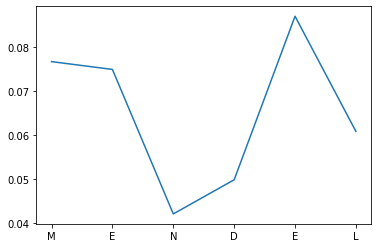

In [14]:
berteome_plot.wtScore_plot(mendel_berteome)

Additionally, you can plot the n_effective to visualize sites that the model infers as having a lower likelyhood of possible substitutions.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc80699d070>)

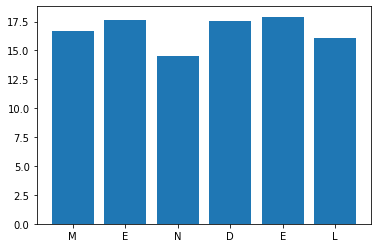

In [16]:
berteome_plot.n_effective_plot(mendel_berteome)

`berteome` also provides a method for visually inspecting the correlations of the amino acid predictions

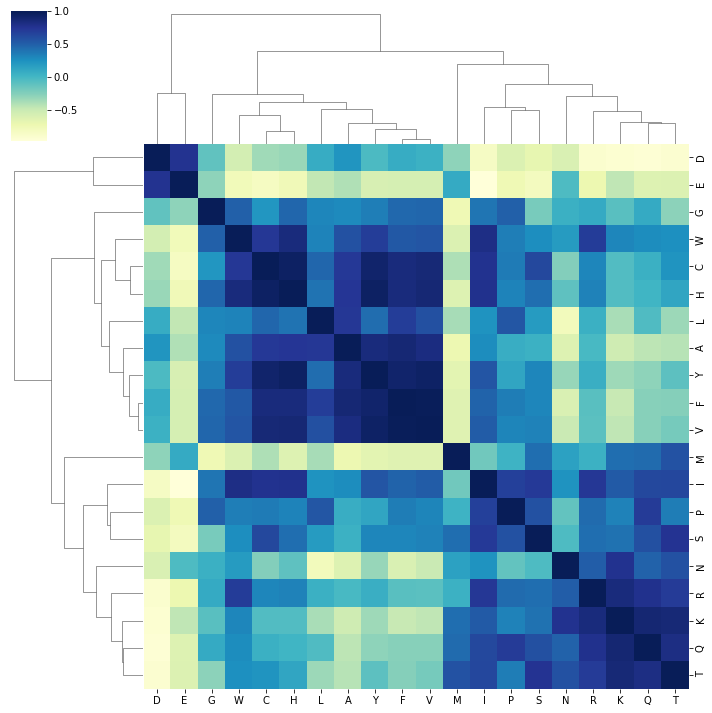

In [17]:
berteome_plot.aa_correlation_plot(mendel_berteome)

If you would like to get a visual of the `berteome` predictions in the form of a `seqlogo`, that can also be accomplished! Doing so potentially reqires having a few additional dependencies installed, something along the lines of:

In [ ]:
!apt install ghostscript

In [ ]:
!apt-get install -y pdf2svg

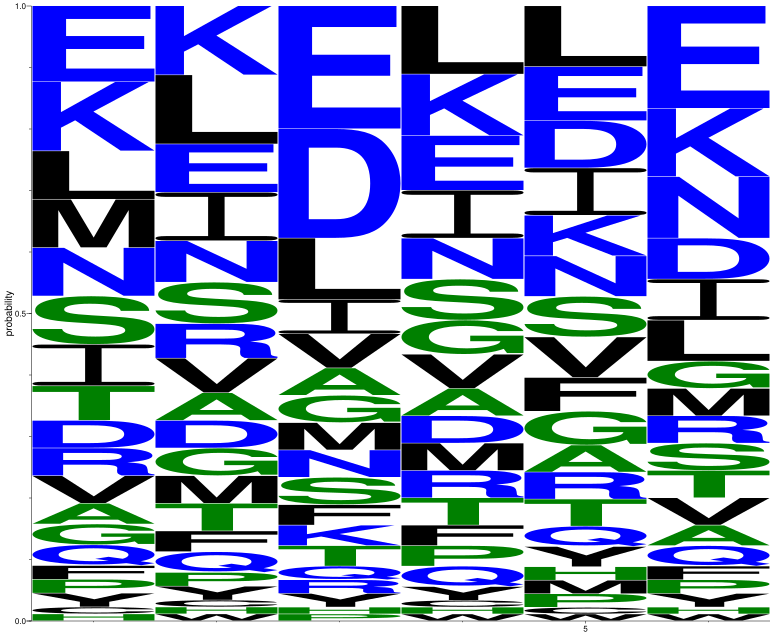

In [20]:
berteome_plot.seqlogo_plot(mendel_berteome)

# Development

To build the library run the following

```
nbdev export
```

Then, pip install in a development environment

```
pip install -e '.[dev]'
```

I do quite a bit of work on a chromebook, which allows for doing stuff on github through codespace and also on google colab. To install a particular commit hash of `berteome` you can do the following:

In [ ]:
!pip uninstall berteome

Found existing installation: berteome 0.1.5
Uninstalling berteome-0.1.5:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/berteome-0.1.5.dist-info/*
    /usr/local/lib/python3.8/dist-packages/berteome/*
Proceed (y/n)? y
  Successfully uninstalled berteome-0.1.5


In [1]:
!pip install "berteome @ git+https://github.com/tijeco/berteome@1e104ce687ed38a21ff72e6b58960aff6e0be6a2"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tijeco/berteome (to revision 1e104ce687ed38a21ff72e6b58960aff6e0be6a2) to /tmp/pip-install-luvjcq66/berteome_93d26519699d4c9c816c0799b9962b68
  Running command git clone --filter=blob:none --quiet https://github.com/tijeco/berteome /tmp/pip-install-luvjcq66/berteome_93d26519699d4c9c816c0799b9962b68
  Running command git rev-parse -q --verify 'sha^1e104ce687ed38a21ff72e6b58960aff6e0be6a2'
  Running command git fetch -q https://github.com/tijeco/berteome 1e104ce687ed38a21ff72e6b58960aff6e0be6a2
  Running command git checkout -q 1e104ce687ed38a21ff72e6b58960aff6e0be6a2
  Resolved https://github.com/tijeco/berteome to commit 1e104ce687ed38a21ff72e6b58960aff6e0be6a2
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━